In [1]:
import pandas as pd
import numpy as np

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s3e5/train.csv")
train.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6


In [3]:
train.shape

(2056, 13)

In [4]:
test = pd.read_csv("/kaggle/input/playground-series-s3e5/test.csv")
test.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
0,2056,7.2,0.510,0.01,2.0,0.077,31.0,54.0,0.99748,3.39,0.59,9.8
1,2057,7.2,0.755,0.15,2.0,0.102,14.0,35.0,0.99586,3.33,0.68,10.0
2,2058,8.4,0.460,0.40,2.0,0.065,21.0,50.0,0.99774,3.08,0.65,9.5
3,2059,8.0,0.470,0.40,1.8,0.056,14.0,25.0,0.99480,3.30,0.65,11.7
4,2060,6.5,0.340,0.32,2.1,0.044,8.0,94.0,0.99356,3.23,0.48,12.8


In [5]:
testid = test['Id']

In [6]:
test.shape

(1372, 12)

In [7]:
original_data = pd.read_csv("/kaggle/input/wine-quality-dataset/WineQT.csv")
original_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,Id
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,1
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,2
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,3
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,4


In [8]:
original_data.shape

(1143, 13)

In [9]:
# adding the source column
original_data['source'] = 0
train['source'] = 1
test['source'] = 1

# combining the datasets
train = pd.concat([train, original_data])
train.reset_index(inplace=True, drop=True)
train.shape

(3199, 14)

In [10]:
# eliminating annoying lgbm warnings, source: https://stackoverflow.com/a/33616192/1105837
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

from lightgbm.sklearn import LGBMClassifier
import lightgbm as lgbm
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [11]:
train = train.drop(['Id'], axis=1)
test = test.drop(['Id'], axis = 1)

In [12]:
train['quality'].value_counts()

5    1322
6    1240
7     476
4      88
8      55
3      18
Name: quality, dtype: int64

In [13]:
train.columns

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality', 'source'],
      dtype='object')

In [14]:
train['AlVAcidity'] = train['alcohol'] + train['volatile acidity']
train['AlCAcid'] = train['alcohol'] + train['citric acid']
train['AlChloride'] = train['alcohol'] + train['chlorides']
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,source,AlVAcidity,AlCAcid,AlChloride
0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6,1,12.60,12.49,12.173
1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6,1,13.10,13.53,12.892
2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7,1,11.81,11.33,11.359
3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5,1,10.67,10.02,9.884
4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6,1,9.86,9.80,9.579


In [15]:
test['AlVAcidity'] = test['alcohol'] + test['volatile acidity']
test['AlCAcid'] = test['alcohol'] + test['citric acid']
test['AlChloride'] = test['alcohol'] + test['chlorides']
test.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,source,AlVAcidity,AlCAcid,AlChloride
0,7.2,0.510,0.01,2.0,0.077,31.0,54.0,0.99748,3.39,0.59,9.8,1,10.310,9.81,9.877
1,7.2,0.755,0.15,2.0,0.102,14.0,35.0,0.99586,3.33,0.68,10.0,1,10.755,10.15,10.102
2,8.4,0.460,0.40,2.0,0.065,21.0,50.0,0.99774,3.08,0.65,9.5,1,9.960,9.90,9.565
3,8.0,0.470,0.40,1.8,0.056,14.0,25.0,0.99480,3.30,0.65,11.7,1,12.170,12.10,11.756
4,6.5,0.340,0.32,2.1,0.044,8.0,94.0,0.99356,3.23,0.48,12.8,1,13.140,13.12,12.844


In [16]:
Quality = train['quality']

In [17]:
train = train.drop(['quality'], axis=1)
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,source,AlVAcidity,AlCAcid,AlChloride
0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,1,12.60,12.49,12.173
1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,1,13.10,13.53,12.892
2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,1,11.81,11.33,11.359
3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,1,10.67,10.02,9.884
4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,1,9.86,9.80,9.579


In [18]:
train.var()

fixed acidity              2.960157
volatile acidity           0.030795
citric acid                0.036593
residual sugar             1.134569
chlorides                  0.001166
free sulfur dioxide      102.317718
total sulfur dioxide    1084.429737
density                    0.000003
pH                         0.021780
sulphates                  0.022658
alcohol                    1.098553
source                     0.229708
AlVAcidity                 1.051560
AlCAcid                    1.171768
AlChloride                 1.086678
dtype: float64

In [19]:
from sklearn.feature_selection import VarianceThreshold

vt = VarianceThreshold()

In [20]:
vt = VarianceThreshold(threshold=0.02)

# Fit
_ = vt.fit(train)

# Get the boolean mask
mask = vt.get_support()

train = train.loc[:, mask]
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol,source,AlVAcidity,AlCAcid,AlChloride
0,8.0,0.50,0.39,2.2,30.0,39.0,3.33,0.77,12.1,1,12.60,12.49,12.173
1,9.3,0.30,0.73,2.3,30.0,67.0,3.32,0.67,12.8,1,13.10,13.53,12.892
2,7.1,0.51,0.03,2.1,3.0,12.0,3.52,0.73,11.3,1,11.81,11.33,11.359
3,8.1,0.87,0.22,2.6,11.0,65.0,3.20,0.53,9.8,1,10.67,10.02,9.884
4,8.5,0.36,0.30,2.3,10.0,45.0,3.20,1.36,9.5,1,9.86,9.80,9.579


In [21]:
train.corr()

,fixed acidity,volatile acidity,citric acid,residual sugar,free sulfur dioxide,total sulfur dioxide,pH,sulphates,alcohol,source,AlVAcidity,AlCAcid,AlChloride
fixed acidity,1.000000,-0.293392,0.687184,0.189630,-0.210055,-0.121732,-0.677651,0.154041,-0.044172,0.015060,-0.095356,0.078667,-0.040163
volatile acidity,-0.293392,1.000000,-0.569957,-0.042999,0.031726,0.080682,0.235270,-0.313613,-0.211462,-0.010209,-0.045007,-0.305470,-0.211155
citric acid,0.687184,-0.569957,1.000000,0.156703,-0.141840,-0.041194,-0.553513,0.288808,0.091327,-0.008282,-0.004190,0.265146,0.097963
residual sugar,0.189630,-0.042999,0.156703,1.000000,0.021727,0.071604,-0.109979,0.027273,0.067626,-0.059966,0.061762,0.093172,0.070619
free sulfur dioxide,-0.210055,0.031726,-0.141840,0.021727,1.000000,0.647198,0.113353,-0.017322,-0.090000,0.063515,-0.086560,-0.112208,-0.091097
total sulfur dioxide,-0.121732,0.080682,-0.041194,0.071604,0.647198,1.000000,-0.032712,-0.080711,-0.271605,0.048351,-0.263801,-0.270262,-0.272293
pH,-0.677651,0.235270,-0.553513,-0.109979,0.113353,-0.032712,1.000000,-0.105495,0.164248,-0.001448,0.208140,0.061219,0.158563
sulphates,0.154041,-0.313613,0.288808,0.027273,-0.017322,-0.080711,-0.105495,1.000000,0.183000,-0.052217,0.133376,0.228228,0.191621
alcohol,-0.044172,-0.211462,0.091327,0.067626,-0.090000,-0.271605,0.164248,0.183000,1.000000,-0.012410,0.985913,0.984394,0.999481
source,0.015060,-0.010209,-0.008282,-0.059966,0.063515,0.048351,-0.001448,-0.052217,-0.012410,1.000000,-0.014431,-0.013480,-0.014812


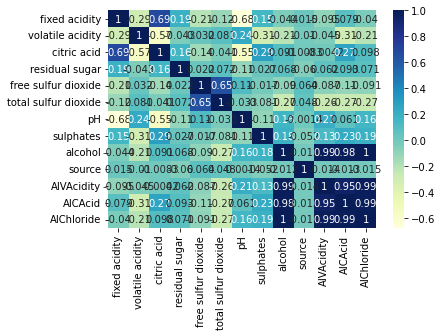

In [22]:
import matplotlib.pyplot as plt
import seaborn as sb

sb.heatmap(train.corr(), cmap="YlGnBu", annot=True)
  
plt.show()

In [23]:
train = train.drop(['AlVAcidity', 'AlCAcid', 'AlChloride'], axis = 1)
test = test.drop(['AlVAcidity', 'AlCAcid', 'AlChloride'], axis = 1)